# Summary

- confirm orbital period of 18.38 within previously reported uncertainty
- orbital period amplitude can be similar to other features
    - less than 0.04 mags
- two big dips separated by 4000 days
- two instances of wide hump/combo of two peaks with barely a drop in-between
- and then similar narrower flares at ~2600 and ~8000
- besides big dip, decent periodicity of ~830-8900; a little complicated by distance to first hump after dip around 3000
- I mag range of 1.16 mags
- V mag range of 0.589 mags
- redder when brighter but two main parts and non-linear
    - most of the trend is actually just from huge dip (see last fig in notebook)

# Outline
- 1: Sequence of Three Auto Functions that Inform Further Search
- 2: Look for Orbital Period with Periodograms
- 3: Look for Orbital Period with LC
- 4: Look for Super-Orbital Period with Periodograms
- 5: Look for Super-Orbital Period with LC

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
# from lmfit.models import GaussianModel
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

In [2]:
cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')
orb = float(cross[cross['src_n']==3]['Porb'])
orb

18.38

## 18.38 $\pm$0.02 from pulsar, and 18.62 ± 0.02 previously using OIII


In [3]:
full[full['src_n']==3]

src_n,OGLE,RA_OGLE,DEC_OGLE,ra_deg,dec_deg,perr,period,Porb,_RAJ2000_1,_DEJ2000_1,__M2002_,Vmag_1,Separation_1,_RAJ2000_2,_DEJ2000_2,Vmag_2,recno,Separation
int64,str38,str11,str11,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64
3,SMC720.17 \#50,00:54:33.44,-73:41:01.3,13.639167,-73.68364,0.8,2.37,18.38,13.639333333333331,-73.68369444444444,30492,14.51,0.2597014565010407,13.639544999999995,-73.68356999999999,14.729,2675272,0.4570936647419033


spin period 2.37 seconds

# 1: Sequence of Three Auto Functions that Inform Further Search

orbital period: 18.38


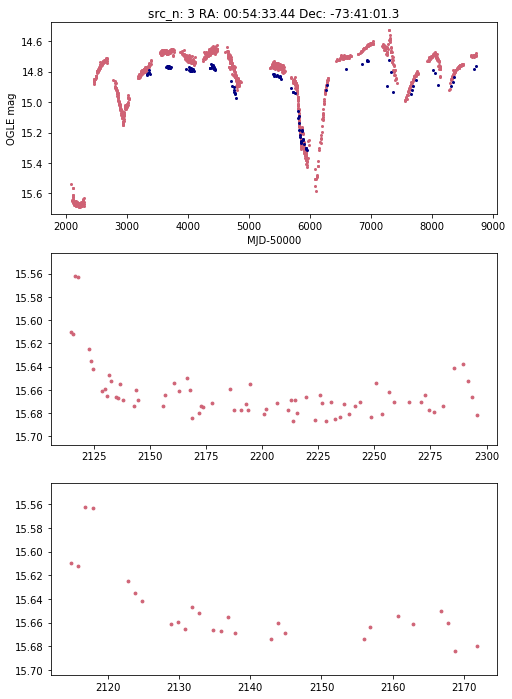

In [4]:
ilist,vlist = o.getIV(3,cross,plot=True,zooms=True,figsize=(8,12),mult=(3,8),offset=10,stack=False) #sometimes good to adjust offset
iband,vband = vstack(ilist),vstack(vlist)

In [5]:
idays = iband['MJD-50000']
imag = iband['I mag']
ierr = iband['I mag err']

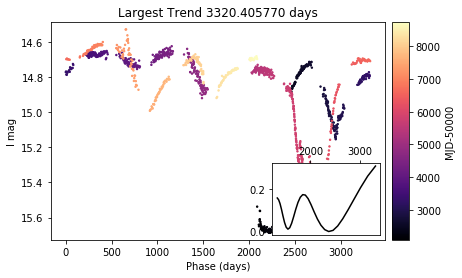

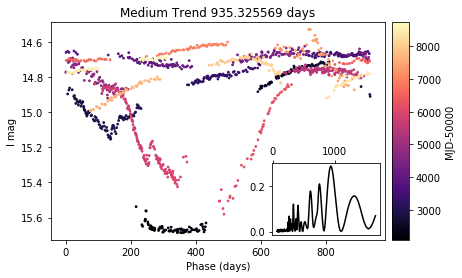

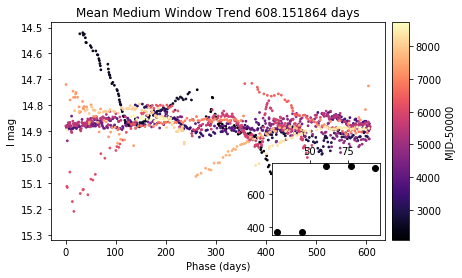

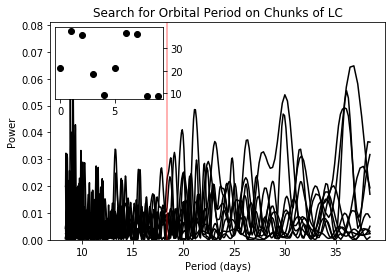

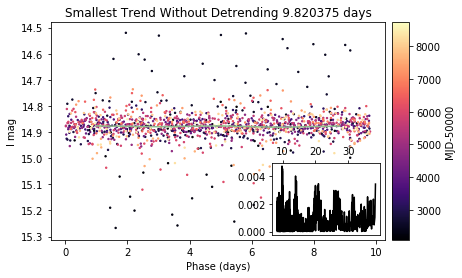

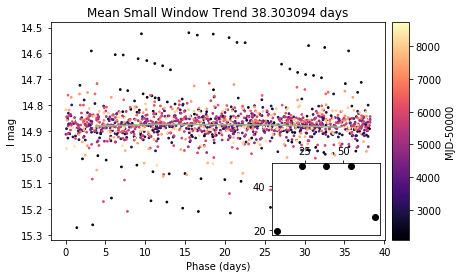

In [6]:
o.autopd(iband,orb,plotpd=True,plotphase=True,printall=False,ctime=True,orb_bounds=(10,20),cutlc=True,numcuts=10,plotdet=True,pbins=5,saveall=False,srcnum=3)

main take-away: best period on chunks looks ~sinusoidal, but could be coincidence. known orb not jumping out

I and V-I correlation: -0.8002922261337712
V and V-I correlation: -0.6698593996852642


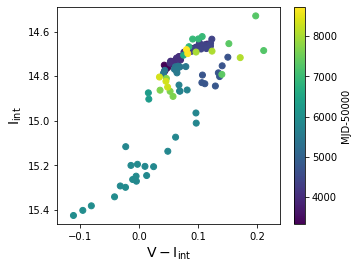

In [7]:
reload(o)
o.colormag(iband,vband,ctime=True) 

# 2: Look for Orbital Period with Periodograms

by OGLE epoch then dense regions (but can be broken up by >20 days)

In [8]:
len(ilist)

2

start ind: 0, end ind: -1
start ind: 0, end ind: -1


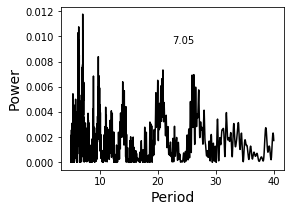

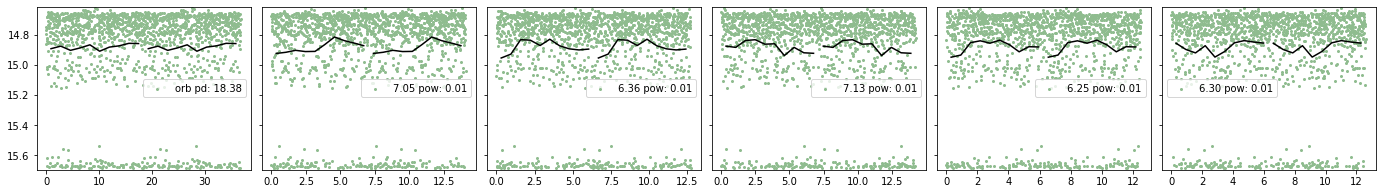

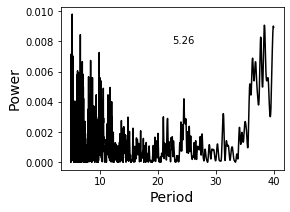

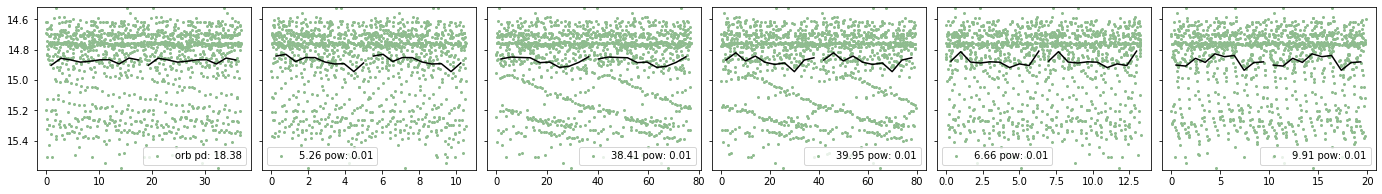

In [9]:
#without detrending
#always get high peak at exactly one day b/c of observing
df,pks = o.multiphase(ilist[0],orb=orb,dense=False,minp=5,maxp=40,plotpd=True)
df,pks = o.multiphase(ilist[1],orb=orb,dense=False,minp=5,maxp=40,plotpd=True)

<Quantity 9.29749028>

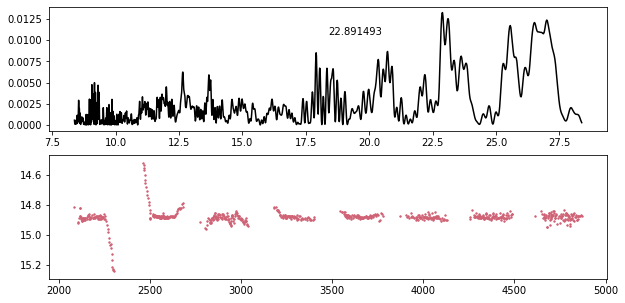

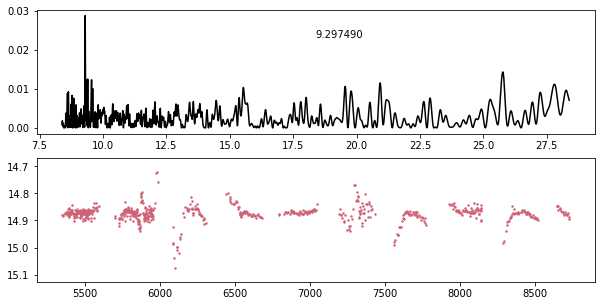

In [10]:
#detrending each OGLE epoch
#pretty consistently getting ~22 and ~9 or both 9 with low window
o.knownorb(ilist[0],orb,lower=10,upper=10,window=31,cutdata=False,cut1=0,cut2=500,plotdet=True,figsize=(10,5))
o.knownorb(ilist[1],orb,lower=10,upper=10,window=31,cutdata=False,cut1=0,cut2=500,plotdet=True,figsize=(10,5))

In [11]:
orb/2

9.19

**separate into regions**

start ind: 850, end ind: 1018


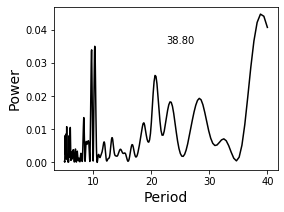

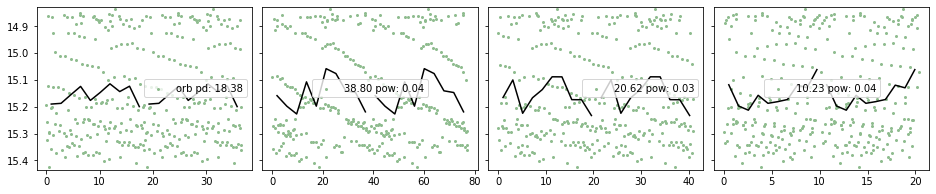

In [12]:
df,pks = o.multiphase(iband,orb=orb,dense=True,minp=5,maxp=40,plotpd=True)

In [13]:
dense,mdense = o.finddense(iband,maxspace=50,retall=True)

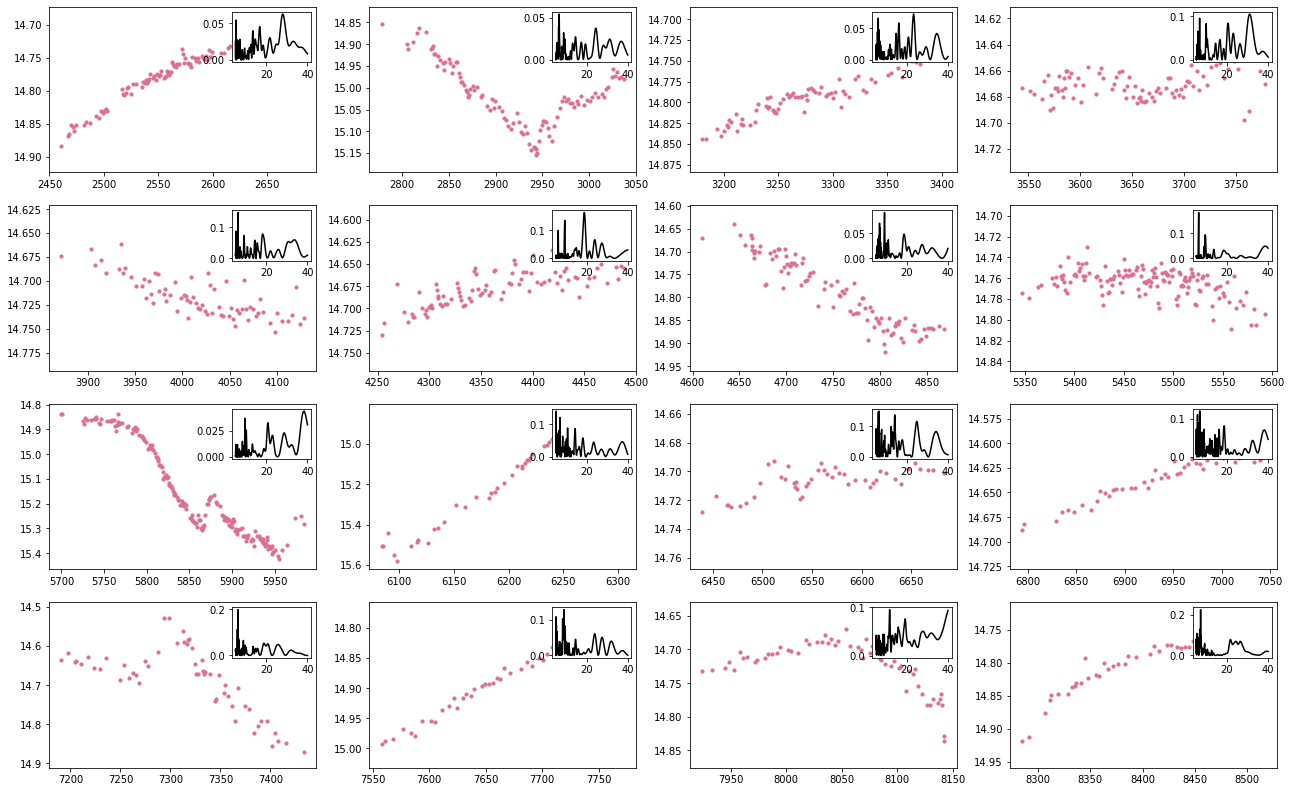

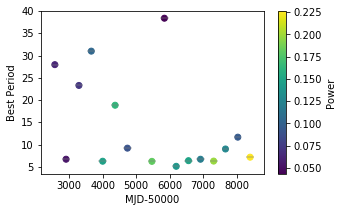

In [14]:
bps,maxpows,stdate,endate = o.denselcpd(iband,dense,maxp=40,plotbest=True,onlybp=True)

search by year

In [15]:
#make tab for each year in LC
years = []
stdate = iband['MJD-50000'][0]
endate = iband['MJD-50000'][-1]
y = 1
while y < int((endate-stdate)/365)+1:
    #less than next year
    year = iband[iband['MJD-50000']<stdate+365*y]
    #also more than previous
    year = year[year['MJD-50000']>stdate+365*(y-1)]

    years.append(year)
    y+=1

In [16]:
years[-1]['MJD-50000'][-1]

8655.93249

In [17]:
len(years)

18

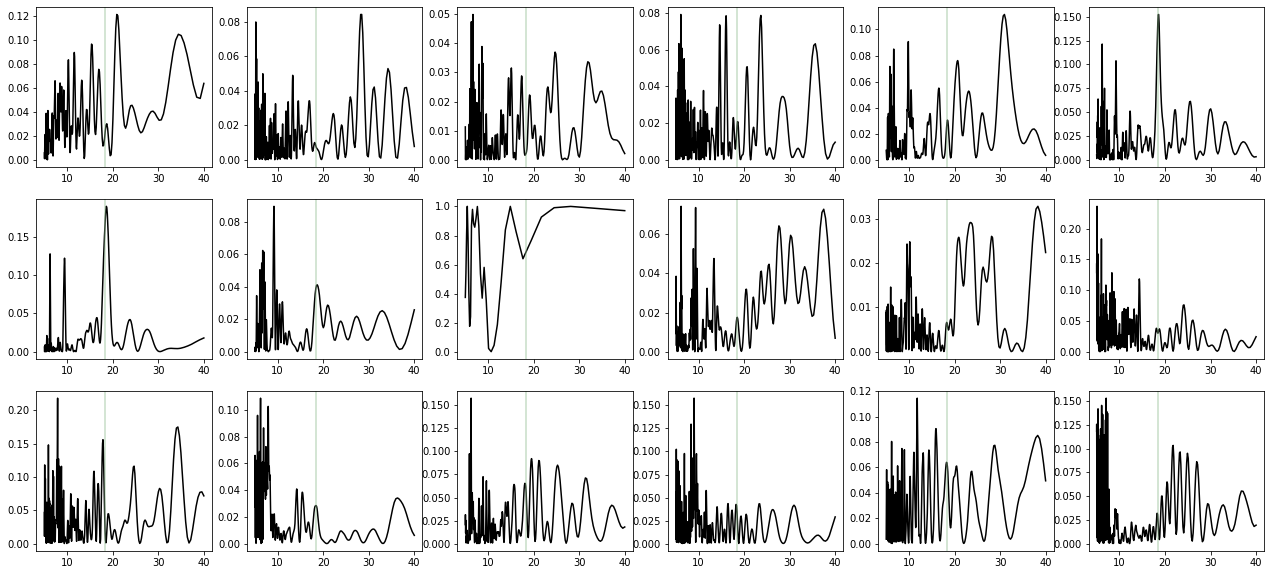

In [18]:
#with multiphase big cell but nice to see what fold of known orb looks like even when it's not a peak
reload(o)
fig = plt.figure(figsize=(22,10))
bps = []
p = 1
for y in years:
# #     df,pks = o.multiphase(y,maxp=40,orb=orb,dense=False,plotpd=True,sigma=5)
    freq,power,bp = o.periodogram(y,maxp=40,more=True,plot=False)
    bps.append(bp)
    ax = fig.add_subplot(3,6,p)
    ax.plot(1/freq,power,color='black')
    ax.axvline(18.38,color='darkseagreen',alpha=0.5)
    p+=1

many different values but often a peak at/near known orbital period
- repeat with detrending and then move on to LC and use it to confirm/adjust orbital period

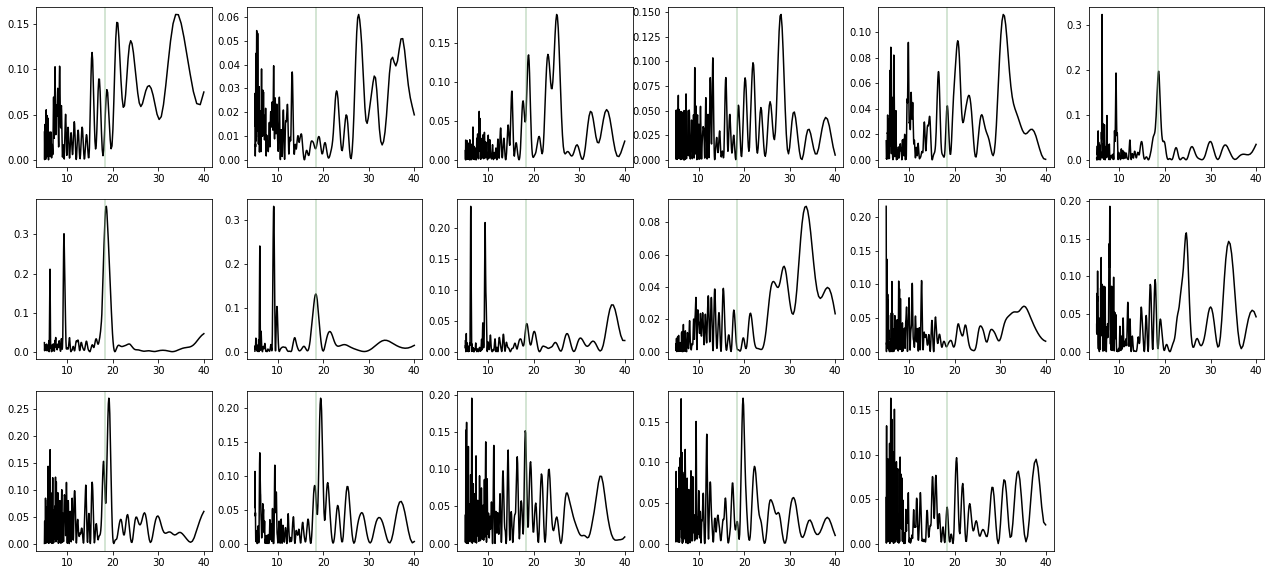

In [19]:
reload(o)
fig = plt.figure(figsize=(22,10))
bps = []
p = 1
for y in years:
    if len(y)>31:
        o.detrend(y,window=31)
        freq,power,bp = o.periodogram(y,maxp=40,more=True,plot=False,det=True)
        bps.append(float(bp))
        ax = fig.add_subplot(3,6,p)
        ax.plot(1/freq,power,color='black')
        ax.axvline(18.38,color='darkseagreen',alpha=0.5)
        p+=1

a lot more effective with detrending, but can fiddle with window

# 3: Look for Orbital Period with LC

In [20]:
orb

18.38

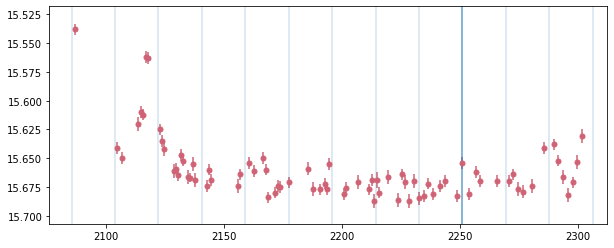

In [21]:
def checkorb(st,end,cen=2251,orb=orb,plcen=False,figsize=(10,4)):
    stday = idays[st:st+1]
    enday = idays[end-1:end]
    fig = plt.figure(figsize=figsize)
    plt.errorbar(idays[st:end],imag[st:end],yerr=ierr[st:end],linestyle='none',marker='o',color=pink,markersize=5)
    maxi,mini = np.max(imag[st:end]),np.min(imag[st:end])
    plt.ylim(maxi+.02,mini-.02)

    fline = int((stday - cen)/orb)
    lline = int((enday - cen)/orb)
    for i in range(fline-1,lline+2):
        plt.axvline(cen+orb*i,alpha=0.2)
    if plcen: plt.axvline(cen,alpha=0.6)
checkorb(0,79,cen=2251,plcen=True)

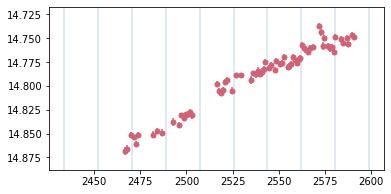

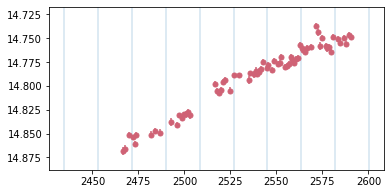

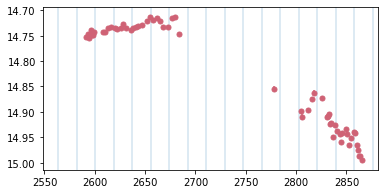

In [22]:
checkorb(80,150,figsize=(6,3),orb=18.3) #better?
checkorb(80,150,figsize=(6,3))
# checkorb(150,210,figsize=(6,3),orb=18.3)
checkorb(150,210,figsize=(6,3))

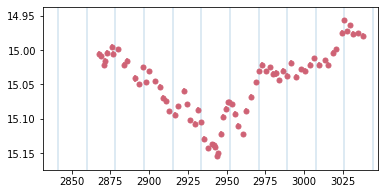

In [23]:
checkorb(210,284,figsize=(6,3),orb=18.45) #better?

this part may just be difficult b/c of larger-amplitude but decently narrow fluctuations interfering? but we will see if this trend continues

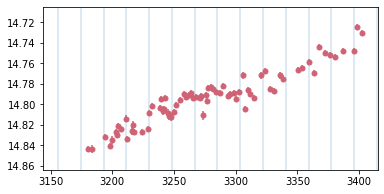

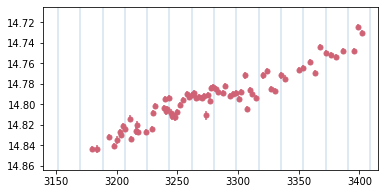

In [24]:
checkorb(284,359,figsize=(6,3),orb=18.45,cen=2252) #testing
checkorb(284,359,figsize=(6,3)) #each have their strengths; again hard to tell b/c of added features

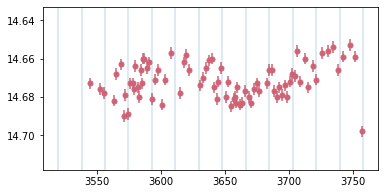

In [25]:
checkorb(359,440,figsize=(6,3)) #all one trend here so difficult

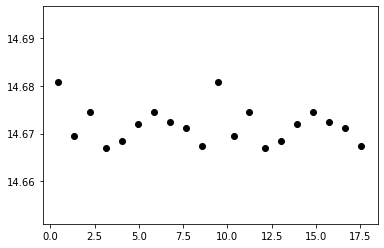

In [26]:
pd = 9
mid,avg = o.meanphase(iband[359:440],pd,pbins=10)
plt.scatter(mid,avg,color='black')
plt.scatter(pd+mid,avg,color='black')

pd = 18.37
# mid,avg = o.meanphase(iband[359:440],pd,pbins=15)
# plt.scatter(mid,avg,color='grey')
# plt.scatter(pd+mid,avg,color='grey')

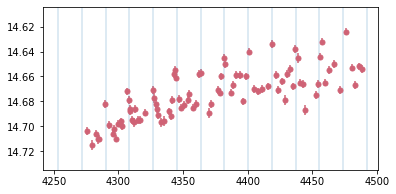

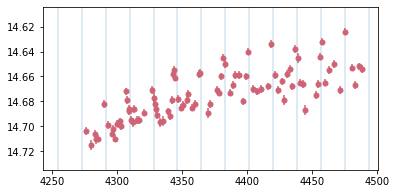

In [27]:
checkorb(520,610,figsize=(6,3),orb=18.37) 
checkorb(520,610,figsize=(6,3),orb=18.38) 

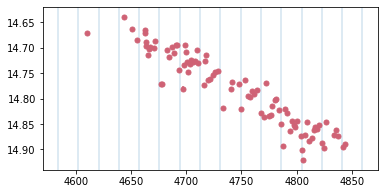

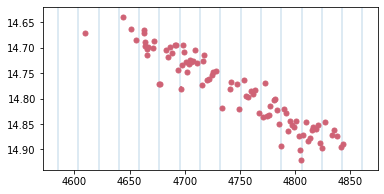

In [28]:
checkorb(610,700,figsize=(6,3),orb=18.37) 
checkorb(610,700,figsize=(6,3),orb=18.38) 

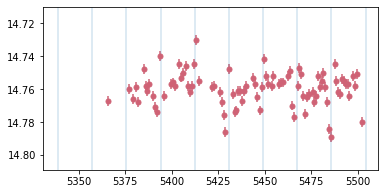

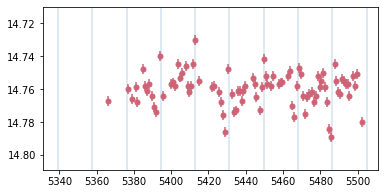

In [29]:
checkorb(710,800,figsize=(6,3),orb=18.38) 
checkorb(710,800,figsize=(6,3),orb=18.383) 

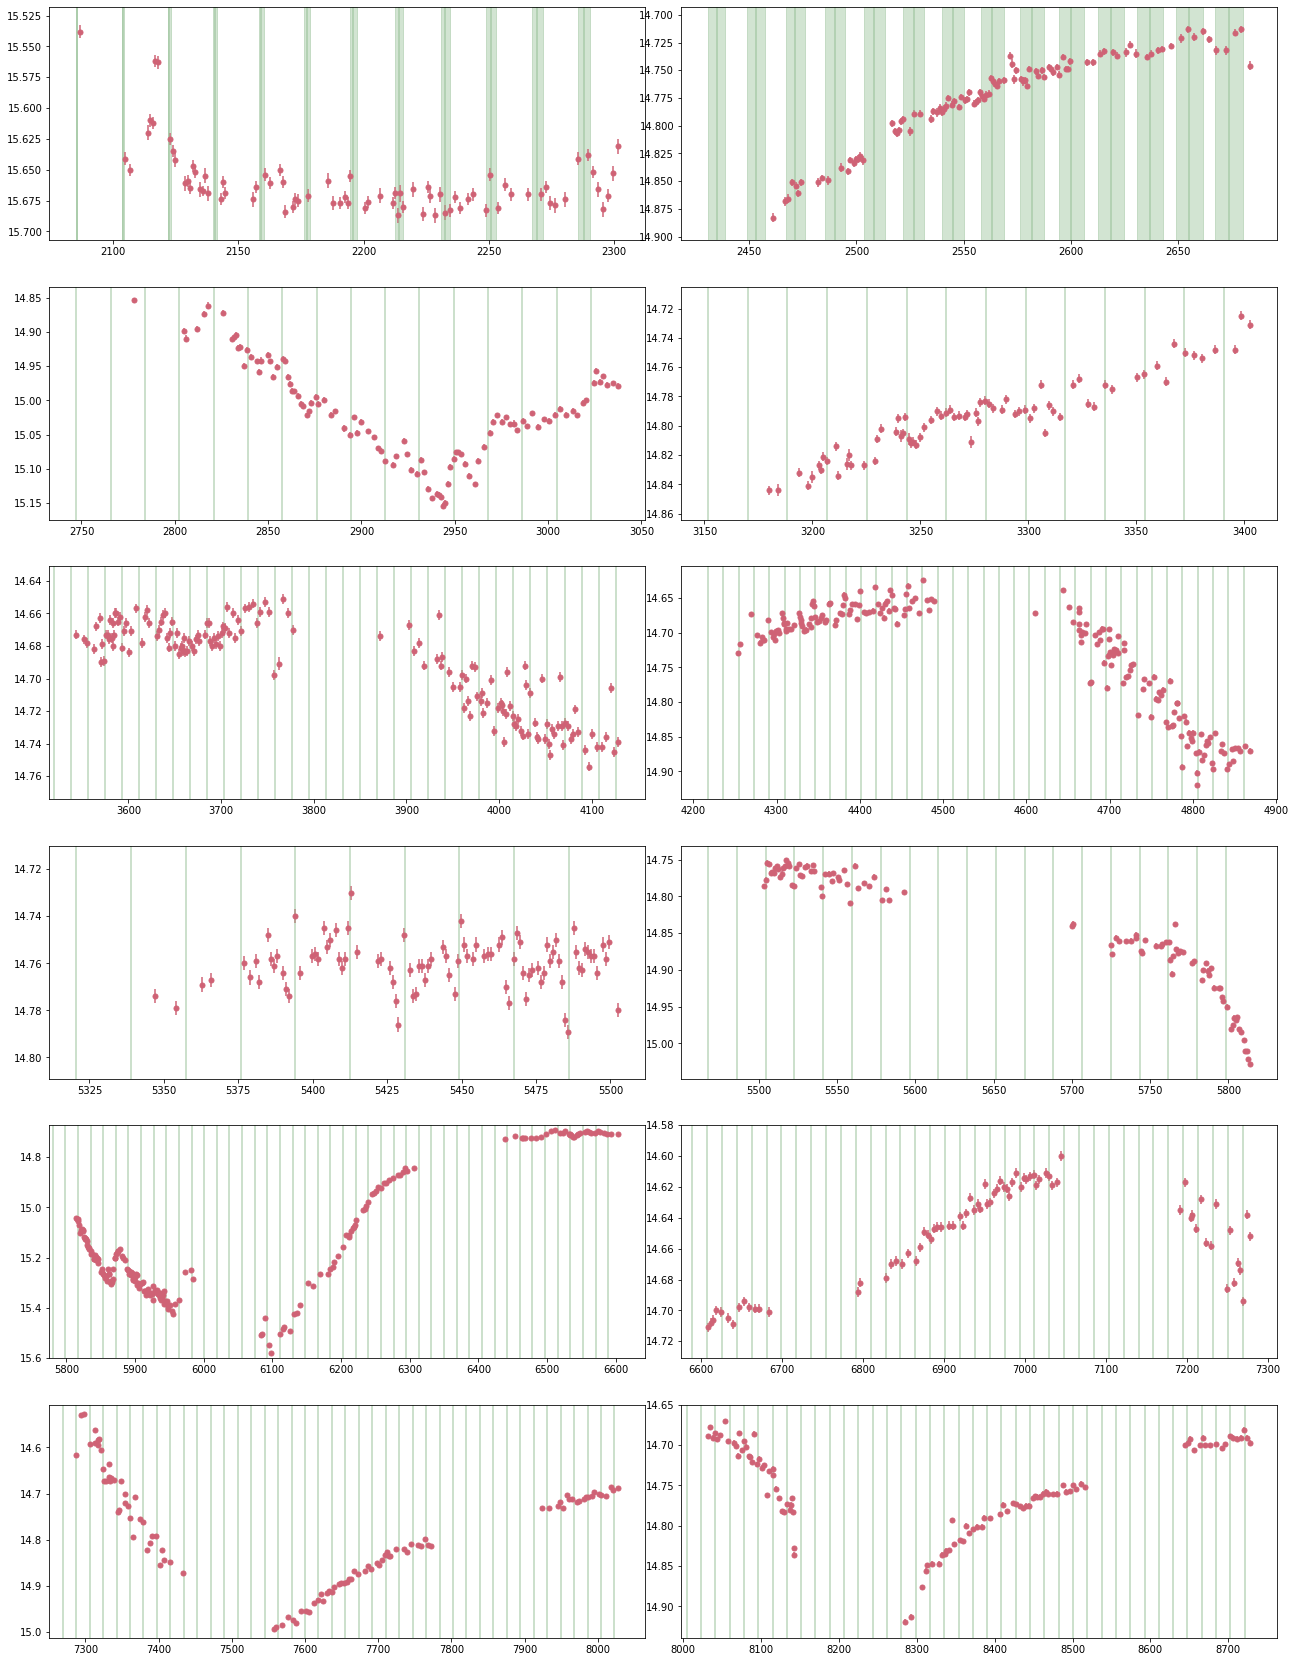

In [30]:
fig = plt.figure(figsize=(22,30))
plnum = 1
ax = fig.add_subplot(6,2,plnum)

def addsub(st=0,end=100,plnum=plnum,cen=2251,cenerr=2,pd=18.381,pderr=0.2,span=True,plcen=False):
    tot = idays[end-1:end] - idays[st:st+1]
    stday = idays[st:st+1]
    enday = idays[end-1:end] 
    
    ax.errorbar(idays[st:end],imag[st:end],yerr=iband['I mag err'][st:end],linestyle='none',marker='o',color=pink,markersize=5)
    maxi,mini = np.max(imag[st:end]),np.min(imag[st:end])
    ax.set_ylim(maxi+.02,mini-.02)
    if plcen: ax.axvline(cen)
    fline = int((stday - cen)/pd)
    lline = int((enday - cen)/pd)
    for i in range(fline-1,lline+1):
        #propogate error of ~3 days and 1 day on period
        if span: ax.axvspan(cen-cenerr+(pd-pderr)*i,cen+cenerr+(pd+pderr)*i,color='darkseagreen',alpha=0.4)
        ax.axvline(cen+pd*i,color='darkseagreen',alpha=0.6)
    plnum1 = plnum+1
    return plnum1

#TO DO: automatic indexing here -- same as finddense with large maxspace
plnum = addsub(st=0,end=79,plcen=False)
ax = fig.add_subplot(6,2,plnum)
plnum = addsub(st=79,end=181,plnum=plnum)
plt.subplots_adjust(wspace=.06)
ax = fig.add_subplot(6,2,plnum)
plnum = addsub(st=181,end=284,plnum=plnum,span=False)
ax = fig.add_subplot(6,2,plnum)
plnum = addsub(st=284,end=359,plnum=plnum,span=False)
ax = fig.add_subplot(6,2,plnum)
plnum = addsub(st=359,end=517,plnum=plnum,span=False)
ax = fig.add_subplot(6,2,plnum)
plnum = addsub(st=517,end=707,plnum=plnum,span=False)
ax = fig.add_subplot(6,2,plnum)
plnum = addsub(st=707,end=800,plnum=plnum,span=False)
ax = fig.add_subplot(6,2,plnum)
plnum = addsub(st=800,end=900,plnum=plnum,span=False)
ax = fig.add_subplot(6,2,plnum)
plnum = addsub(st=900,end=1100,plnum=plnum,span=False)
ax = fig.add_subplot(6,2,plnum)
plnum = addsub(st=1100,end=1177,plnum=plnum,span=False)
ax = fig.add_subplot(6,2,plnum)
plnum = addsub(st=1177,end=1280,plnum=plnum,span=False)
ax = fig.add_subplot(6,2,plnum)
plnum = addsub(st=1280,end=1383,plnum=plnum,span=False)


can play around with orbital period and center, but approximately right

# 4: Look for Super-Orbital Period with Periodograms

start ind: 0, end ind: -1
start ind: 0, end ind: -1


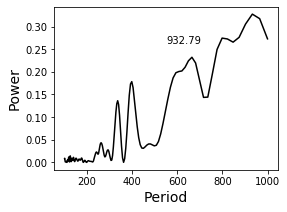

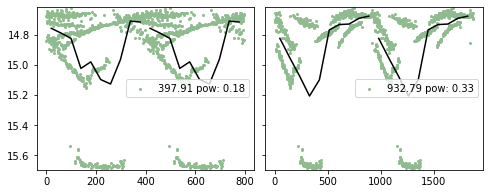

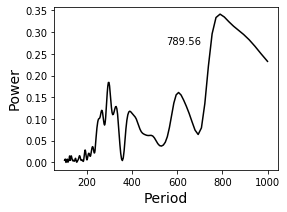

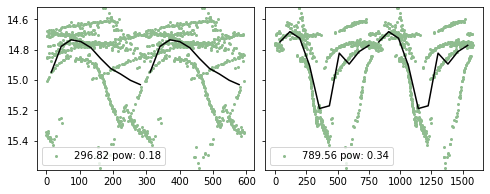

In [31]:
#each OGLE epoch
df,pks = o.multiphase(ilist[0],orb=orb,incl_orb=False,dense=False,minp=100,maxp=1000,plotpd=True)
df,pks = o.multiphase(ilist[1],orb=orb,incl_orb=False,dense=False,minp=100,maxp=1000,plotpd=True)

start ind: 0, end ind: -1


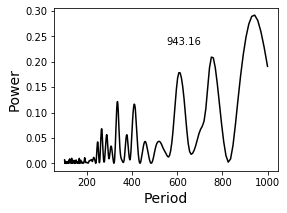

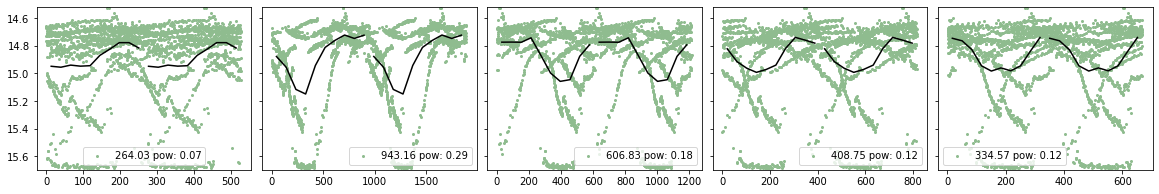

In [32]:
#full LC
df,pks = o.multiphase(iband,orb=orb,incl_orb=False,dense=False,minp=100,maxp=1000,plotpd=True)

# 5: Look for Super-Orbital Period with LC

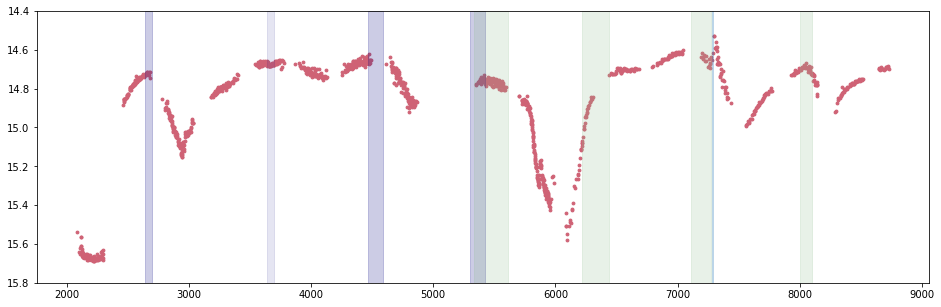

In [33]:
plt.figure(figsize=(16,5))
plt.scatter(idays,imag,color=pink,s=8)
plt.ylim(15.8,14.4)
plt.axvspan(2640,2700,color='navy',alpha=0.2)
#first big hump 1000 days away
plt.axvspan(2640+1000,2700+1000,color='navy',alpha=0.1)
#following two peaks each separate by ~850 days
plt.axvspan(2640+1830,2700+1890,color='navy',alpha=0.2)
plt.axvspan(2640+2660,2700+2720,color='navy',alpha=0.2)
# plt.axvspan(2640+2660+830,2700+2720+890,color='navy',alpha=0.2)


plt.axvspan(8000,8100,color='darkseagreen',alpha=0.2)
plt.axvspan(8000-890,8100-830,color='darkseagreen',alpha=0.2)
plt.axvspan(8000-890*2,8100-830*2,color='darkseagreen',alpha=0.2)
plt.axvspan(8000-890*3,8100-830*3,color='darkseagreen',alpha=0.2)

plt.axvline(7288.6,alpha=0.4) #that feature is from an X-ray outburst

**two big dips separated by 4000 days**
- two instances of wide hump/combo of two peaks with barely a drop in-between
- and then similar narrower flares at ~2600 and ~8000
- besides big dip, decent periodicity of ~830-8900; a little complicated by distance to first hump after dip around 3000

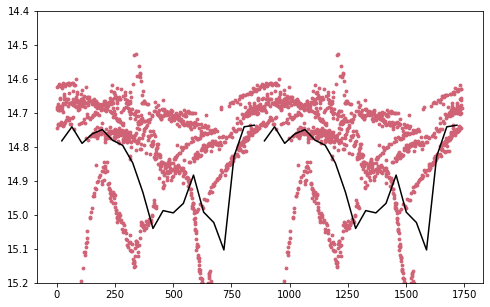

In [34]:
plt.figure(figsize=(8,5))
pd = 870
plt.scatter(idays%pd,imag,color=pink,s=8)
plt.scatter(pd+idays%pd,imag,color=pink,s=8)
plt.ylim(15.2,14.4)
mid,avg = o.meanphase(iband,pd)
plt.plot(mid,avg,color='black')
plt.plot(pd+mid,avg,color='black')

if we exclude big dip

In [35]:
iband[705:710]

MJD-50000,I mag,I mag err,I detrend
float64,float64,float64,float64
4862.56986,14.863,0.003,14.929887523097937
4868.56023,14.87,0.003,14.936838140381887
5346.92112,14.774,0.003,14.841739374949778
5353.93132,14.779,0.003,14.847628263838672
5362.93963,14.769,0.003,14.838208510752256


In [41]:
inodip = iband[np.abs(6000-iband['MJD-50000'])>500]
#also get rid of first dip
inodip = inodip[inodip['MJD-50000']>2400]

# vnodip = vband[np.abs(6000-vband['MJD-50000'])>500]
# #also get rid of first dip
# vnodip = vnodip[vnodip['MJD-50000']>2400]

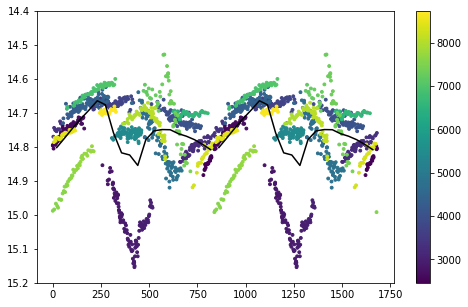

In [37]:
plt.figure(figsize=(8,5))
#most flares best in 800s, but dip at 3000 a bit out of phase
pd = 840

plt.scatter(inodip['MJD-50000']%pd,inodip['I mag'],c=inodip['MJD-50000'],s=8)
plt.scatter(pd+inodip['MJD-50000']%pd,inodip['I mag'],c=inodip['MJD-50000'],s=8)
plt.ylim(15.2,14.4)
mid,avg = o.meanphase(inodip,pd)
plt.plot(mid,avg,color='black')
plt.plot(pd+mid,avg,color='black')
plt.colorbar()

I and V-I correlation: -0.4829940882510073
V and V-I correlation: 0.07841371293435676


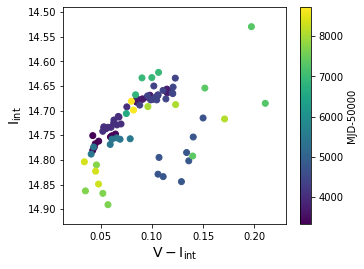

In [45]:
#color-mag without dip
reload(o)
o.colormag(inodip,vnodip,ctime=True) 